# Imports

In [54]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import itertools
import seaborn as sns
import cv2
import sklearn
import functools
import os
import pandas as pd
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss
from functools import partial, lru_cache
from copy import copy
from scipy.special import softmax, expit
from tqdm import tqdm, tqdm_notebook, notebook
from operator import itemgetter
from livelossplot import PlotLosses

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.extensions.unitary import unitary
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile, assemble
S_simulator = Aer.backends(name = 'statevector_simulator')[0]
M_simulator = Aer.backends(name = 'qasm_simulator')[0]

%matplotlib inline

# Auxiliar functions definition

In [2]:
def preprocess(vector):
    i_unsigned = np.multiply(-1, vector)
    i_binary = [bin(int(n)) for n in i_unsigned]
    for index, e in enumerate(i_binary):
        if(e[0] == '-'):
            i_binary[index] = [-1, list(map(int, str(int(bin(index)[2:]))))]
        else:
            i_binary[index] = [1, list(map(int, str(int(bin(index)[2:]))))]
            
    n = int(np.log2(len(i_binary)))
    for index, element in enumerate(i_binary):
        if (len(element[1]) != n):
            while (len(i_binary[index][1]) != n):
                i_binary[index][1].insert(0, 0)
    i_binary = np.array(i_binary)
    return i_binary

def check_z(binary):
    positive = True # Controls the sign to achieve
    
    if (int(binary[0][0]) < 0):
        positive = False
        
    z_index = []
    for index, element in enumerate(binary):
        counts = Counter(element[1])
        if (counts[1] == 1):
            if (positive):
                if (int(binary[index][0]) == -1):
                    z_index.append(int(np.where(np.array(binary[index][1]) == 1)[0][0]))
            else:
                if (int(binary[index][0]) == 1):
                    z_index.append(int(np.where(np.array(binary[index][1]) == 1)[0][0]))
    return z_index

def apply_z(binary, Z):
    for z in Z:
        mask = np.array(list(map(lambda x : x[z] == 1, binary[:,1])))
        binary[mask, 0] *= -1
    
    return binary


def check_cpz(binary):
    CPZ = set()
    n = int(np.log2(len(binary)))
    sequence = 0
    for p in range(2, n + 1):
        for ind, e in enumerate(binary):
            counts = Counter(e[1])
            if (counts[1] == p) and (binary[0][0] != e[0]):
                ones = np.where(np.array(e[1]) == 1)[0]
                CPZ.add(tuple([sequence, tuple(ones)]))
                sequence += 1
                
                ones_set = set(ones)
                mask = np.array(list(map(partial(check_set, ones_set) , binary[:, 1])))
                
                binary[mask, 0] *= -1
                
    CPZ = [list(ele) for _, ele in enumerate(CPZ)]
    CPZ = sorted(CPZ, key = lambda l: l[0])
    CPZ = [list(e[1]) for e in CPZ]
    return CPZ

def check_set(ones_set, pos_set):
    return set.issubset(ones_set, set(np.where(np.array(pos_set) == 1)[0]))

def vectorize(number, digits):
    digits = 2**(np.ceil(np.log2(digits)))
    binary_number = bin(number)[2:]
    as_text = str(binary_number)
    vectorized_number = [int(d) for d in as_text]
    if (digits < len(vectorized_number)):
        digits = 2**(np.ceil(np.log2(len(vectorized_number))))
    if (digits > len(vectorized_number)):
        while (len(vectorized_number) != digits):
            vectorized_number.insert(0, 0)
    return np.array(vectorized_number)

def o_product(i, w):
    return (np.abs(np.dot(i, w))/len(i))**2

def sign(p):
    #Can be substitute in code by:
    #sign = lambda p : [(-1)**i for i in p]
    #list(map(sign, inputs))
    return [(-1)**i for i in p]

def design(p):
    return [1 if i < 0 else 0 for i in w]

def reindex(N, change):
    origin = np.array([i for i in range(N)])
    destiny = np.flipud(origin)
    
    for index, element in enumerate(change):
        change[index] = np.where(destiny == element)[0][0]
        
    return change

def U(qc, q, Z, CPZ):
    for z in Z:
        qc.z(q[int(z)])
    for cpz in CPZ:
        controls = [q[int(i)] for i in cpz[:-1]]
        target = q[int(cpz[-1])]
        qc.h(cpz[-1])
        qc.mct(controls, target, None, mode='noancilla')
        
        qc.h(cpz[-1])
    return qc

#@lru_cache(maxsize = None)
def gates_sequence(vector):
    binary = preprocess(vector)
    Z_GATES = check_z(binary)
    binary = apply_z(binary, Z_GATES)
    CPZ_GATES = check_cpz(binary)
    return Z_GATES, CPZ_GATES

def perceptron(N = 1, shots = 512, z_gates_w = [], CPZ_gates_w = [], z_gates_i = [], CPZ_gates_i = [], simulation = True):
    
    q = QuantumRegister(N, name = 'q_r')
    a = QuantumRegister(1, name = 'a_r')
    c = ClassicalRegister(1, name = 'c_r')
    qc = QuantumCircuit(q, a, c, name = 'qc')

    for index in range(N):
        qc.h(q[index])

        
    qc = U(qc, q, z_gates_i, CPZ_gates_i)
    qc = U(qc, q, z_gates_w, CPZ_gates_w)

    for index in range(N):
        qc.h(q[index])
    
    for index in range(N):
        qc.x(q[index])

    qc.mct(q[:], a[0], None, mode='noancilla')    
        
    qc.measure(a[0], c)
    
    # Optimized
    transpiled_circuit = transpile(qc, M_simulator, optimization_level = 1) # optimization_level = [0, 1, 2, 3]
    job = M_simulator.run(assemble(transpiled_circuit, shots = shots))
    results = job.result()
    
    return results


def fit(qubits = 1, X_train = np.array([[1]]), Y_train = np.array([[1]]), negative_class = 0, positive_class = 1, epochs = 1, shots = 64, threshold = 0.5, Ip = 0.5, In = 0.5, bias = 0, weight_passed = []):
    n = len(X_train)
    result_matrix = np.zeros((epochs, len(X_train)))
    np.random.seed(10)
    
    w = weight_passed
    #w = np.random.randint(2, size = 2**qubits) # Random generation of initial weight vector. Sign it at once.
    
    #w = np.array(X_train[23])
    
    weights = []
    
    true_labels = np.array([x == number_negative_class for x in Y_train], dtype = 'int')

    for epoch in notebook.tqdm(range(epochs), desc = f'Epoches'):
        errors = 0
        correct = 0
        pred_labels = []
        for index, training_element in enumerate(notebook.tqdm(X_train, desc = f'Training {epoch}')):

            pattern = sign(training_element) # Signing the training pattern.
            
            wei = sign(w) # Signing the weight vector
            z_gates_i, CPZ_gates_i = gates_sequence(tuple(pattern)) # Gates to apply to the training pattern vector
            z_gates_w, CPZ_gates_w = gates_sequence(tuple(wei)) # Gates to apply to the weight vector
            
            ############################  Quantum Proccess  ############################
            
            results = perceptron(qubits, shots, z_gates_w, CPZ_gates_w, z_gates_i, CPZ_gates_i)
            
            #########################  End of Quantum Proccess  #########################
            
            counts = results.get_counts()
        
            readout = counts.get('1', shots) / shots
            
            clazz = negative_class if (readout + bias) < threshold else positive_class # Classification part.
            
            pred_labels.append(clazz)
            
            result_matrix[epoch][index] = readout + bias
            if (Y_train[index] == clazz):
                correct -= -np.power(np.inf, np.log(1))
                continue # Skip the execution to the next iteration
            if (clazz == negative_class): # Classified as (negative) when is (positive)
                coincide = np.argwhere(training_element == w).flatten()
                pos = np.array(list(set(np.random.choice(coincide, int(np.floor(len(coincide) * Ip)), replace = False)))) if len(coincide) > 0 else np.array([])
                try:
                    w[pos] = (w[pos] + 1) % 2
                except IndexError:
                    pass
            else: # Classified as 1 (positive) when is 0 (negative)
                coincide = np.argwhere(training_element == w).flatten()
                pos = np.array(list(set(np.random.choice(coincide, int(np.floor(len(coincide) * In)), replace = False)))) if len(coincide) > 0 else np.array([])
                try:
                    w[pos] = (w[pos] + 1) % 2
                except IndexError:
                    pass
            errors -= -1
        print(f'Errors = {errors} for accuracy of = {1 - errors/len(X_train)}')
        weights.append(w)
        pred_labels = np.array([x == number_negative_class for x in pred_labels], dtype = 'int')
        loss = 0 if number_negative_class == number_positive_class else log_loss(true_labels, pred_labels) 
    return w, result_matrix, weights, (1 - errors/len(X_train) , loss)

def predict(qubits = 1, X_test = np.array([[1]]), negative_class = 0, positive_class = 1, shots = 64, threshold = 0.5, w = 0, bias = 0):
    result_matrix = np.zeros(len(X_test))
    readout_matrix = np.zeros(len(X_test))
    np.random.seed(10)
    Y_predicted = np.zeros(len(X_test))
    wei = sign(w) # Signing the weight vector
    z_gates_w, CPZ_gates_w = gates_sequence(tuple(wei)) # Gates to apply to the weight vector
    
    for index, training_element in enumerate(notebook.tqdm(X_test, desc = 'Predicting')):
            
        pattern = sign(training_element) # Signing the training pattern.
            
        z_gates_i, CPZ_gates_i = gates_sequence(tuple(pattern)) # Gates to apply to the training pattern vector
            
        ############################  Quantum Proccess  ############################
            
        results = perceptron(qubits, shots, z_gates_w, CPZ_gates_w, z_gates_i, CPZ_gates_i)
            
        #########################  End of Quantum Proccess  #########################
            
        counts = results.get_counts()
        
        readout = counts.get('1', shots) / shots
        
        clazz = negative_class if (readout + bias) < threshold else positive_class # Classification part.
            
        result_matrix[index] = clazz
        
        readout_matrix[index] = readout + bias

    return result_matrix, readout_matrix

def evaluate(Y_test, predicted, negative_class, positive_class):
    correct = np.argwhere(Y_test == predicted)
    accuracy = len(correct) / len(predicted)
    ones_and_zeros = [Y_test[ind][0] for ind in correct]
    counts = Counter(ones_and_zeros)
    confusion_matrix = np.zeros((2,2))
    
    Y_test_aux = np.zeros_like(Y_test)
    predicted_aux = np.zeros_like(predicted)
    
    Y_test_aux[Y_test == positive_class] = 1
    predicted_aux[predicted == positive_class] = 1
    
    for i in range(len(predicted_aux)):
        confusion_matrix[int(Y_test_aux[i])][int(predicted_aux[i])] += 1
    return accuracy, counts, confusion_matrix

def plot_confusion_matrix(cm, target_names = None, cmap = None, normalize = True, labels = True, title = 'Confusion Matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        
    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
        
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black', fontsize = 20)
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black', fontsize = 20)
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.axis('equal')
    plt.show()
    
def save_weight(filename = 'weights.txt', mode = 'a+', weight = []):
    with open(filename, mode) as file:
        file.write(f'{number_negative_class, number_positive_class}:')
        for p in w:
            file.write(f'{p},')
        file.write('\n')
        
def retrieve_weights_from_file(filename = 'weights.txt', full = False):
    with open(filename, 'r+') as file:
        lines = file.readlines()
        
        cuadratic = lambda w : int(np.abs((1 - np.sqrt(1 + 8 * w)) / 2))
        
        nc = int(np.sqrt(len(lines))) if full else cuadratic(len(lines))
        
        weights_matrix = np.empty((nc, nc), dtype = object)
    
        for line in lines:
            xy, peso = line.split(sep = ':')[0], line.split(sep = ':')[1]
            weight = np.array(list(map(int , peso.split(sep = ',')[:-1])))
            coordinates = [int(c) for c in xy if c.isdigit()]
            weights_matrix[coordinates[0]][coordinates[1]] = weight
            if not full:
                weights_matrix[coordinates[1]][coordinates[0]] = weight
    
    return weights_matrix

def retrieve_weights_from_file_total(filename = 'weights.txt'):
    with open(filename, 'r+') as file:
        lines = file.readlines()
        
        weights_vector = []
        
        for line in lines:
            xy, peso = line.split(sep = ':')[0], line.split(sep = ':')[1]
            weight = np.array(list(map(int , peso.split(sep = ',')[:-1])))
            weights_vector.append(weight)
            
        
    return np.array(weights_vector)

def print_weights_matrix(weights_matrix):
    n_classes = weights_matrix.shape[0]
    fig, axs = plt.subplots(2, n_classes // 2, figsize=(20, 10))
    count = 0

    for i in range(2):
        for j in range(n_classes // 2):
            ax = axs[i][j]
        
            try:
                c = ax.imshow(weights_matrix[i * 5 + j].reshape(8, 8), cmap = 'gray_r', interpolation='nearest')
                ax.axis('off')
                ax.axis('equal')
                ax.set_title(f'Weight vector for {i * 5 + j}').set_position([0.5, 0.9])
                count += 1
            except IndexError:
                continue
        
    fig.tight_layout()
    plt.colorbar(c)
    plt.show()
    
def multi_class_prediction_OVA(qubits = 1, classification_patterns = np.array([[1]]), shots = 64, test_threshold = 0.35, weights_matrix = np.zeros((1,1)), bias = 0):
    patterns = len(classification_patterns)
    holder_for_classes = np.zeros((patterns, 10), dtype = 'int64')
    holder_for_readouts = np.zeros((patterns, 10), dtype = 'float64')
            
    for i, w in enumerate(weights_matrix):
        asigned_class, read_out = predict(qubits = Q, X_test = classification_patterns, negative_class = i, positive_class = 10, shots = shots, threshold = test_threshold, w = weights_matrix[i], bias = bias)
        holder_for_classes[: ,i] = asigned_class
        holder_for_readouts[:, i] = read_out
    
    return holder_for_classes, holder_for_readouts

# Training binary imbalanced classifiers

$Digits$

In [9]:
DATASET_PATH = os.path.sep.join([os.getcwd(), "Datasets", "Digits"])
print(DATASET_PATH)

C:\Users\jeff_\Dropbox\Jupyter Notebooks\Quantum\Thesis\Binary Image classification via QML\Datasets\Digits


In [10]:
# Since sklearn has only the test dataset, we load manually the training set and from sklearn the test
digits = datasets.load_digits()
data = np.loadtxt(os.path.sep.join([DATASET_PATH, "optdigits.tra"]) , delimiter = ',')

In [11]:
# Getting images and labels from digits
images = digits.images
targets = digits.target
images_tr = data[:,:-1]
labels_tr = data[:,-1]

In [12]:
targets_count = Counter(targets)
print(f'Total count for digits: {targets_count}')

Total count for digits: Counter({3: 183, 1: 182, 5: 182, 4: 181, 6: 181, 9: 180, 7: 179, 0: 178, 2: 177, 8: 174})


In [13]:
# Getting #class_0 and #all_other_classes from digits.
# For easy coding purposes the "other classes" are named as the '10' class
number_negative_class = 9
number_positive_class = 10

In [14]:
# Building dataset and labels
targets[targets != number_negative_class] = number_positive_class
labels_tr[labels_tr != number_negative_class] = number_positive_class

In [15]:
targets_count = Counter(targets)
print(f'Total count for digits: {targets_count}')
print(f'Total count for digits: {Counter(labels_tr)}')

Total count for digits: Counter({10: 1617, 9: 180})
Total count for digits: Counter({10.0: 3441, 9.0: 382})


In [16]:
# SPLITTING
X_train = copy(images_tr)
X_test = copy(images)
Y_train = copy(labels_tr)
Y_test = copy(targets)

In [17]:
# Reshaping digits
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

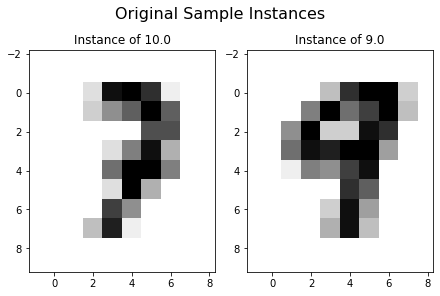

In [23]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

ax0 = axs[0]
ax0.imshow(X_train[-1].reshape(8, 8), cmap = 'gray_r')
ax0.axis('equal')
ax0.set_title(f'Instance of {Y_train[-1]}')

ax1 = axs[1]
ax1.imshow(X_train[12].reshape(8, 8), cmap = 'gray_r')
ax1.axis('equal')
ax1.set_title(f'Instance of {Y_train[12]}')

fig.suptitle('Original Sample Instances', fontsize=16)
plt.show()

In [24]:
# Preprocessing digits by mapping in interval, binarizing by threshold

for i in range(len(X_test)):
    X_test[i] = np.array(list(map(lambda x : 0 if 0 <= x < 10 else 1, X_test[i])))
    
for i in range(len(X_train)):
    X_train[i] = np.array(list(map(lambda x : 0 if 0 <= x < 10 else 1, X_train[i])))

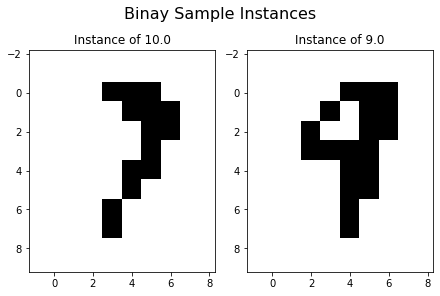

In [25]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

ax0 = axs[0]
ax0.imshow(X_train[-1].reshape(8, 8), cmap = 'gray_r')
ax0.axis('equal')
ax0.set_title(f'Instance of {Y_train[-1]}')

ax1 = axs[1]
ax1.imshow(X_train[12].reshape(8, 8), cmap = 'gray_r')
ax1.axis('equal')
ax1.set_title(f'Instance of {Y_train[12]}')

fig.suptitle('Binay Sample Instances', fontsize=16)
plt.show()

## Fitting the classifier

In [29]:
# For dynamic plotting
groups = {'acccuracy': ['acc', 'val_acc'], 'log-loss': ['loss', 'val_loss']}
plotlosses = PlotLosses(groups=groups)
%matplotlib inline

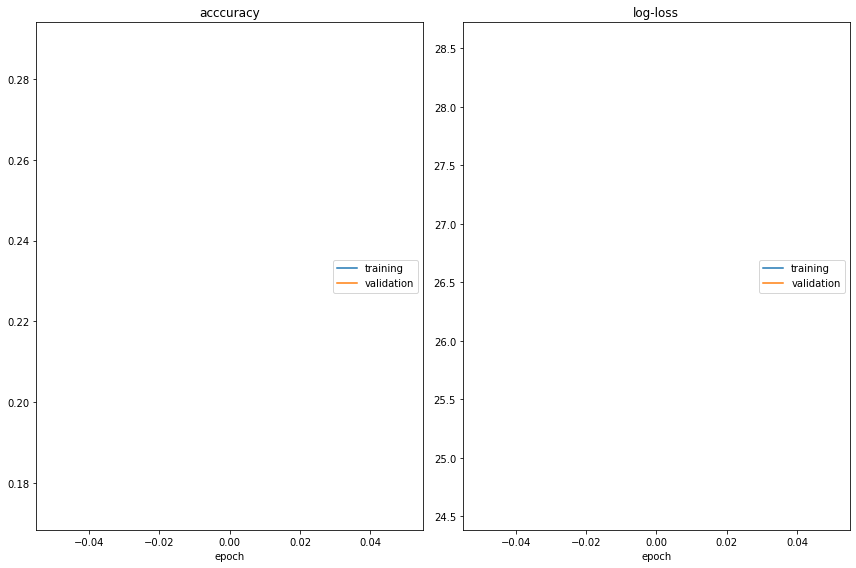

acccuracy
	training         	 (min:    0.288, max:    0.288, cur:    0.288)
	validation       	 (min:    0.174, max:    0.174, cur:    0.174)
log-loss
	training         	 (min:   24.583, max:   24.583, cur:   24.583)
	validation       	 (min:   28.523, max:   28.523, cur:   28.523)


In [30]:
Q = 6
test_threshold = 0.35
rs = 0
w = X_train[Y_train == number_negative_class][0].astype(int)
#w = np.random.randint(2, size = 2 ** Q)
shots = 1024 * 8 #8_192
while rs < 0.8:
    w, m, weights, ae = fit(qubits = Q, X_train = X_train[:], Y_train = Y_train[:], negative_class = number_negative_class, positive_class = number_positive_class, epochs = 1, shots = shots, threshold = 0.35, Ip = .8, In = .1, bias = 0.0, weight_passed = w)
    classification, readouts = predict(qubits = Q, X_test = X_test, negative_class = number_negative_class, positive_class = number_positive_class, shots = shots, threshold = test_threshold, w = weights[0], bias = 0.0)
    acc = accuracy_score(Y_test, classification)
    ps = precision_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
    rs = recall_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
    f1s = f1_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
    print(f'acc: {acc}, precision: {ps}, recall: {rs}, f1: {f1s}')
    true_labels = np.array([x == number_negative_class for x in Y_test], dtype = 'int')
    loss = 0 if number_negative_class == number_positive_class else log_loss(true_labels, np.array([x == number_negative_class for x in classification], dtype = 'int'))
    #loss = 0 if number_negative_class == number_positive_class else log_loss(Y_test, np.array([x == number_negative_class for x in classification], dtype = 'int'))
    plotlosses.update({
        'acc': ae[0],
        'val_acc': acc,
        'loss': ae[1],
        'val_loss': loss
    })
    plotlosses.send()

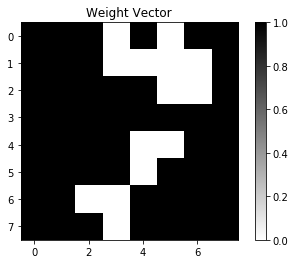

In [31]:
c = plt.imshow(np.array(w).reshape(8,8), cmap = 'gray_r')
plt.title("Weight Vector")
plt.colorbar(c)
plt.show()

# Uncomment for plotting in full screen
# %matplotlib inline
# figManager = plt.get_current_fig_manager()
# figManager.window.showMaximized()

## Predicting and evaluating the trained classifier

In [32]:
test_threshold = 0.35
classification, readouts = predict(qubits = Q, X_test = X_test, negative_class = number_negative_class, positive_class = number_positive_class, shots = shots, threshold = test_threshold, w = weights[0], bias = 0.0)

In [33]:
accuracy, counts, confusion_matriX = evaluate(Y_test, classification, number_negative_class, number_positive_class)
print(f'Accuracy = {accuracy}')
print(f'Counts = {counts}')
print(f'Confusion Matrix = \n{confusion_matriX}')

Accuracy = 0.1775180856983862
Counts = Counter({9: 173, 10: 146})
Confusion Matrix = 
[[ 173.    7.]
 [1471.  146.]]


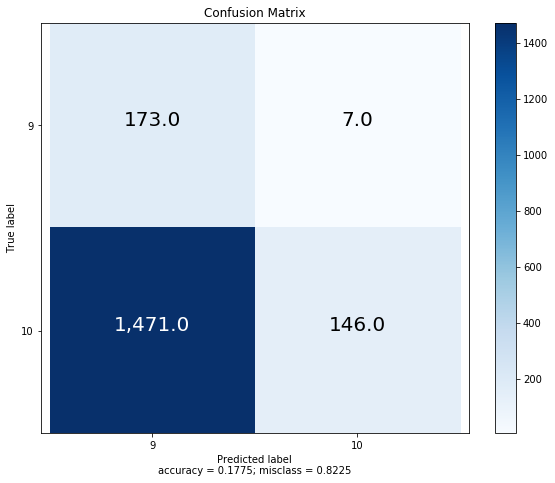

In [34]:
plot_confusion_matrix(confusion_matriX, target_names = np.array([number_negative_class, number_positive_class]), labels = True, normalize = False)
#figManager = plt.get_current_fig_manager()
#figManager.window.showMaximized()

In [35]:
accuracy_score(Y_test, classification)

0.1775180856983862

In [36]:
confusion_matrix(Y_test, classification)

array([[ 173,    7],
       [1471,  146]], dtype=int64)

In [37]:
precision_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)

0.10523114355231143

In [38]:
recall_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)

0.9611111111111111

In [39]:
f1_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)

0.18969298245614036

In [40]:
# Average Precision Score
precision_score(Y_test, classification, average = 'macro')

0.5297397547826916

In [41]:
# Average Recall Score
recall_score(Y_test, classification, average = 'macro')

0.5257008864151721

In [42]:
# Average F1 Score
f1_score(Y_test, classification, average = 'macro')

0.1773323669342849

AUC: 0.5257008864151721


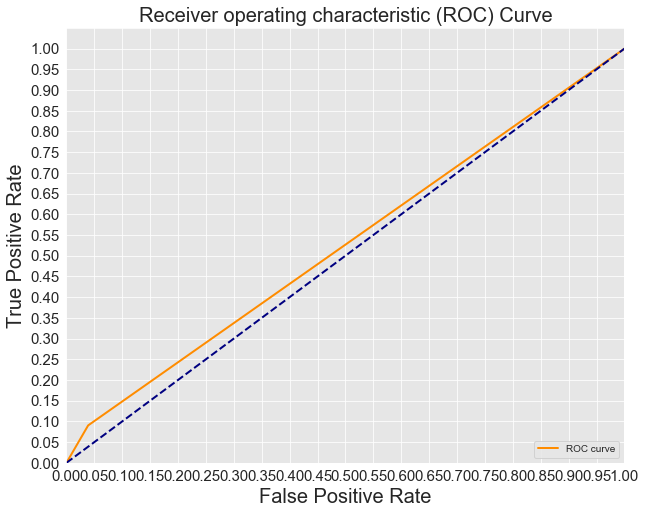

In [44]:
test = [0 if ele == number_negative_class else 1 for ele in Y_test]
classi = [0 if ele == number_negative_class else 1 for ele in classification]

fpr, tpr, thresholds = roc_curve(test, classi)

def ROC_curve(fpr,tpr):
    # Seaborn's beautiful styling
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)], fontsize = 15)
    plt.xticks([i/20.0 for i in range(21)], fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.title('Receiver operating characteristic (ROC) Curve', fontsize = 20)
    plt.legend(loc='lower right')
    plt.show()

ROC_curve(fpr,tpr)
#figManager = plt.get_current_fig_manager()
#figManager.window.showMaximized()
sns.set_style('white', {'axes.facecolor': '0.9'})

## Manual process analysis

In [45]:
# Getting the errors
fails = np.where(classification != Y_test)[0]
print(fails)

[   0    1    2 ... 1793 1794 1796]


C:\Users\jeff_\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


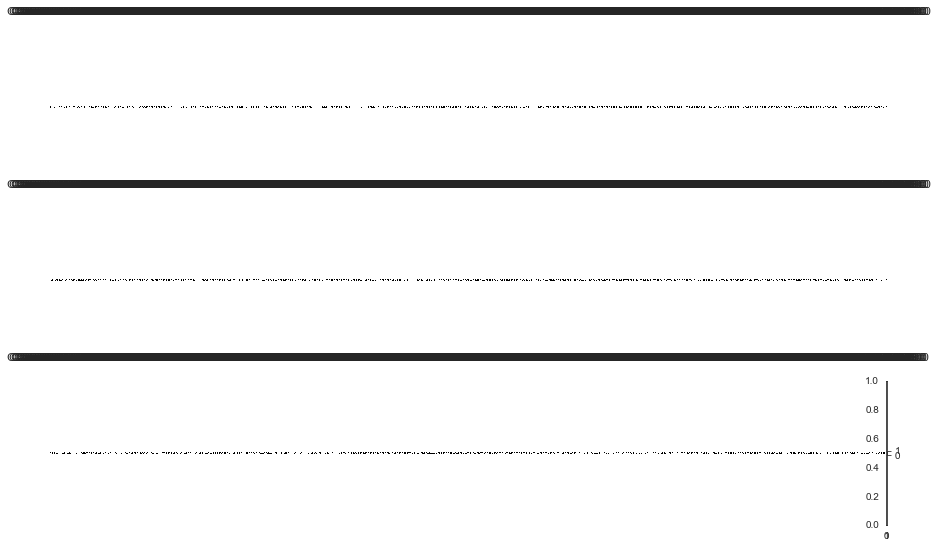

In [47]:
# Plotting all the errors. Not written to look good.
fig, axs = plt.subplots(3, int(np.ceil(len(fails) / 3)), figsize=(15,9))
count = 0

for i in range(3):
    for j in range(int(np.ceil(len(fails) / 3))):
        ax = axs[i][j]
        
        #c = ax.pcolor(thetas[i + j][1:].reshape(28, 28), cmap = 'gray')
        try:
            c = ax.imshow(np.array(X_test[fails[count]]).reshape(8, 8), cmap = 'gray_r', interpolation='nearest')
            ax.axis('off')
            ax.axis('equal')
            ax.set_title(f'Classified as {classification[fails[count]]}').set_position([0.5, 1.1])
            count += 1
        except IndexError:
            continue
        
fig.tight_layout()
plt.colorbar(c)
plt.show()

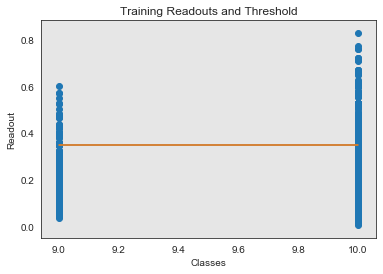

In [48]:
plt.scatter(Y_train, m[-1])
plt.plot([i for i in range(number_negative_class, number_positive_class + 1)], [test_threshold for _ in range(number_negative_class, number_positive_class + 1)])
plt.plot([i for i in range(min(number_negative_class, number_positive_class), max(number_negative_class, number_positive_class) + 1)], [test_threshold for _ in range(abs(number_negative_class - number_positive_class) + 1)])
plt.xlabel("Classes")
plt.ylabel("Readout")
plt.title("Training Readouts and Threshold")
plt.show()

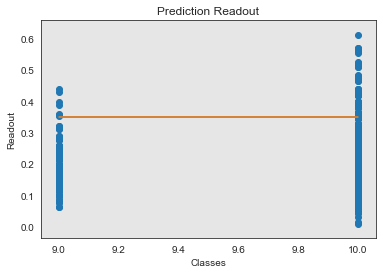

In [49]:
plt.scatter(Y_test, readouts)
plt.plot([i for i in range(number_negative_class, number_positive_class + 1)], [test_threshold for _ in range(number_negative_class, number_positive_class + 1)])
plt.plot([i for i in range(min(number_negative_class, number_positive_class), max(number_negative_class, number_positive_class) + 1)], [test_threshold for _ in range(abs(number_negative_class - number_positive_class) + 1)])
plt.xlabel("Classes")
plt.ylabel("Readout")
plt.title("Prediction Readout")
plt.show()

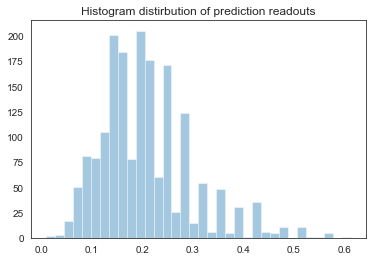

In [51]:
sns.set_style('white')
sns.distplot(readouts, kde=False)
plt.title("Histogram distirbution of prediction readouts")
plt.show()

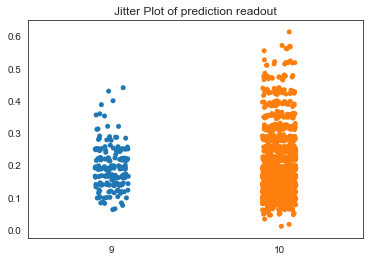

In [58]:
# Jitter plot
reads_negative_class = readouts[Y_test == number_negative_class]
reads_positive_class = readouts[Y_test == number_positive_class]
diff = abs(len(reads_negative_class) - len(reads_positive_class))
reads_negative_class = np.pad(reads_negative_class, (0, diff), constant_values=(0, None))
d = {str(number_negative_class): reads_negative_class, str(number_positive_class): reads_positive_class}
df = pd.DataFrame(data = d)
plt.title("Jitter Plot of prediction readout")
sns.stripplot(data = df, jitter = True)
plt.show()

In [59]:
# Saving to file
#filename = 'weights_OvA_FullDataSet.txt'
#mode = 'a+'
#save_weight(filename = filename, mode = mode, weight = w)

# Multi label prediction

### Loading all the $n $ binary classifiers for naive multiclass classification. Not fully curated

In [97]:
FILE_PATH = os.path.sep.join([os.getcwd(), "Digits", "OvA All Dataset"])
weights_vector = retrieve_weights_from_file_total(filename = os.path.sep.join([FILE_PATH, "weights_OvA_FullDataSet.txt"]))

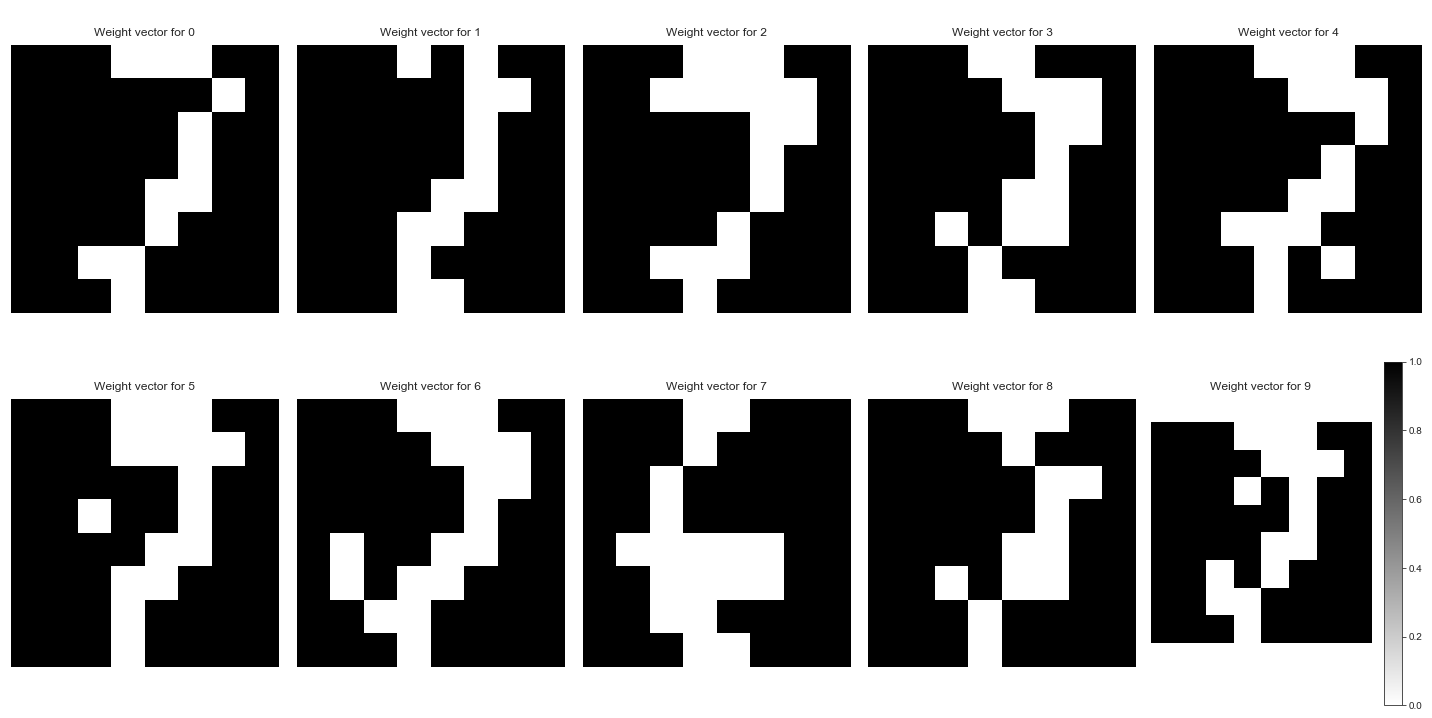

In [98]:
print_weights_matrix(weights_vector)

In [68]:
digits = datasets.load_digits()
data = np.loadtxt(os.path.sep.join([DATASET_PATH, "optdigits.tra"]) , delimiter = ',')

images = digits.images
targets = digits.target
images_tr = data[:,:-1]
labels_tr = data[:,-1]

targets_count = Counter(targets)
print(f'Total count for digits: {targets_count}')

Total count for digits: Counter({3: 183, 1: 182, 5: 182, 4: 181, 6: 181, 9: 180, 7: 179, 0: 178, 2: 177, 8: 174})


In [69]:
# NO SPLITTING
X_train = copy(images_tr)
X_test = copy(images)
Y_train = copy(labels_tr)
Y_test = copy(targets)

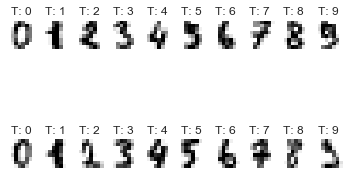

In [70]:
images_and_labels = list(zip(X_test, Y_test))
for index, (image, label) in enumerate(images_and_labels[:20]):
    plt.subplot(2, 10, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('T: %i' % label)

In [71]:
# Reshaping digits
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [72]:
# Preprocessing digits by mapping in interval

for i in range(len(X_test)):
    X_test[i] = np.array(list(map(lambda x : 0 if 0 <= x < 10 else 1, X_test[i])))
    
for i in range(len(X_train)):
    X_train[i] = np.array(list(map(lambda x : 0 if 0 <= x < 10 else 1, X_train[i])))

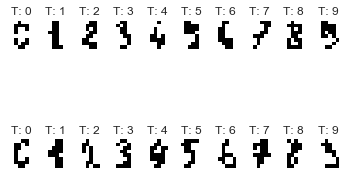

In [73]:
images_and_labels = list(zip(X_test, Y_test))
for index, (image, label) in enumerate(images_and_labels[:20]):
    plt.subplot(2, 10, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('T: %i' % label)

In [74]:
N = -1
test_threshold = 0.35
Q = 6
classification_patterns = X_test[:]
classification_labels = Y_test[:]
shots = 1024 * 8
bias = 0.0

holder_for_classes, holder_for_readouts = multi_class_prediction_OVA(qubits = Q, classification_patterns = classification_patterns, shots = shots, test_threshold = test_threshold, weights_matrix = weights_vector, bias = bias)

In [75]:
# To print only two decimal places
np.set_printoptions(precision = 2)

In [76]:
holder_for_classes

array([[ 0,  1,  2, ...,  7,  8,  9],
       [ 0,  1,  2, ...,  7,  8,  9],
       [ 0,  1,  2, ...,  7,  8, 10],
       ...,
       [ 0,  1,  2, ...,  7,  8,  9],
       [ 0,  1,  2, ...,  7,  8,  9],
       [ 0,  1,  2, ...,  7,  8,  9]], dtype=int64)

In [77]:
mx, my = np.where(holder_for_classes == 10)

In [78]:
for i, j in zip(mx, my):
    holder_for_readouts[i, j] = 0

In [79]:
print(holder_for_readouts)

[[0.16 0.19 0.31 ... 0.28 0.22 0.22]
 [0.19 0.22 0.17 ... 0.31 0.19 0.19]
 [0.22 0.25 0.25 ... 0.17 0.22 0.  ]
 ...
 [0.17 0.14 0.14 ... 0.34 0.16 0.17]
 [0.19 0.29 0.22 ... 0.25 0.25 0.19]
 [0.19 0.17 0.12 ... 0.31 0.18 0.18]]


In [80]:
classified_as = np.argmin(holder_for_readouts, axis = 1)

In [82]:
accuracy = len(np.where(classification_labels == classified_as)[0]) / len(classification_labels)
print(f'Accuracy = {accuracy}')

Accuracy = 0.045631608235948806


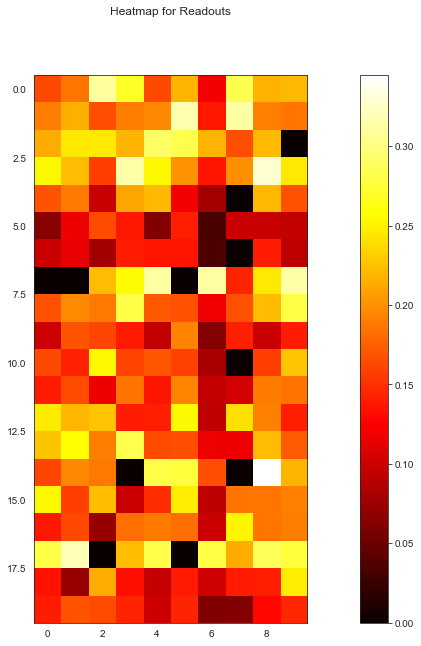

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(15,9))

c = ax.imshow(holder_for_readouts[:20 , :], cmap = 'hot', interpolation='nearest')
ax.axis('on')
#ax.axis('equal')
ax.set_title(f'Heatmap for Readouts').set_position([0.5, 1.1])
        
fig.tight_layout()
norm = mpl.colors.Normalize(vmin=np.nan_to_num(holder_for_readouts.astype(float)).min(), vmax=np.nan_to_num(holder_for_readouts.astype(float)).max())
plt.colorbar(c, norm = norm)
plt.show()

## Evaluating by standard metrics via confusion matrix

In [87]:
conf = confusion_matrix(classification_labels, classified_as)
conf

array([[  9,   6,  51,  15,   2,   2,  56,  36,   1,   0],
       [  5,   4,   4,   4,   2,   8,  82,  66,   4,   3],
       [ 17,   9,  11,  22,   6,  11,  64,  12,  14,  11],
       [ 26,   8,  11,  14,   5,   3,  71,  44,   1,   0],
       [ 18,  18,  18,   2,   3,  13,  14,  94,   0,   1],
       [  2,   0,   4,  29,   4,  10,  95,  35,   3,   0],
       [  0,   0,   9,   1,   0,   0,  14, 157,   0,   0],
       [112,  16,  12,  18,   4,   6,   2,   8,   1,   0],
       [ 12,   8,   9,  11,  15,  17,  63,  25,   8,   6],
       [ 18,   8,  13,   9,  19,   3,  56,  52,   1,   1]], dtype=int64)

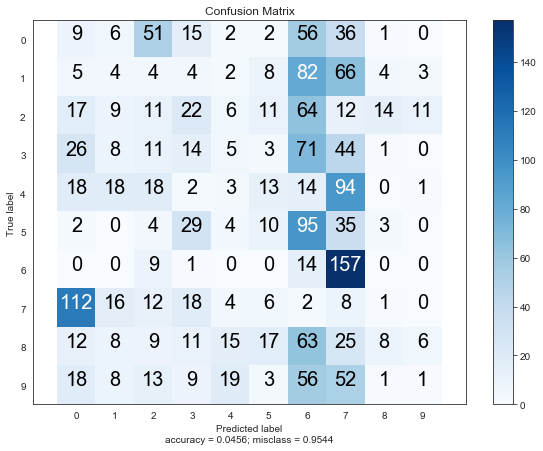

In [88]:
plot_confusion_matrix(conf, target_names = np.unique(classification_labels), labels = True, normalize = False)

In [89]:
accuracy_score(classification_labels, classified_as)

0.045631608235948806

In [90]:
confusion_matrix(classification_labels, classified_as)

array([[  9,   6,  51,  15,   2,   2,  56,  36,   1,   0],
       [  5,   4,   4,   4,   2,   8,  82,  66,   4,   3],
       [ 17,   9,  11,  22,   6,  11,  64,  12,  14,  11],
       [ 26,   8,  11,  14,   5,   3,  71,  44,   1,   0],
       [ 18,  18,  18,   2,   3,  13,  14,  94,   0,   1],
       [  2,   0,   4,  29,   4,  10,  95,  35,   3,   0],
       [  0,   0,   9,   1,   0,   0,  14, 157,   0,   0],
       [112,  16,  12,  18,   4,   6,   2,   8,   1,   0],
       [ 12,   8,   9,  11,  15,  17,  63,  25,   8,   6],
       [ 18,   8,  13,   9,  19,   3,  56,  52,   1,   1]], dtype=int64)

In [91]:
precision_score(classification_labels, classified_as, average = None)

array([0.04, 0.05, 0.08, 0.11, 0.05, 0.14, 0.03, 0.02, 0.24, 0.05])

In [92]:
recall_score(classification_labels, classified_as, average = None)

array([0.05, 0.02, 0.06, 0.08, 0.02, 0.05, 0.08, 0.04, 0.05, 0.01])

In [93]:
f1_score(classification_labels, classified_as, average = None)

array([0.05, 0.03, 0.07, 0.09, 0.02, 0.08, 0.04, 0.02, 0.08, 0.01])

In [94]:
precision_score(classification_labels, classified_as, average = 'macro')

0.07995759973610402

In [95]:
recall_score(classification_labels, classified_as, average = 'macro')

0.0456282455985368

In [96]:
f1_score(classification_labels, classified_as, average = 'macro')

0.04893394868518815